In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import collections
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from PIL import Image

from skimage.io import imread
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset

torch.manual_seed(42)

## Data Path

In [2]:
Path = '/CV_projects/Arthropod_tax/ArTaxOr'
folders_name = [ 'Araneae','Coleoptera','Diptera','Hemiptera','Hymenoptera','Lepidoptera','Odonata']

In [3]:
images = []
labels = []

for folders in folders_name:
    dir = os.path.join(Path, folders)
    for file in os.listdir(dir):
        if file !="annotations":
            images.append(file)
            labels.append(folders)

data = {'images':images, 'labels': labels}
data = pd.DataFrame(data)
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15376 entries, 0 to 15375
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  15376 non-null  object
 1   labels  15376 non-null  object
dtypes: object(2)
memory usage: 240.4+ KB


## Data visualization

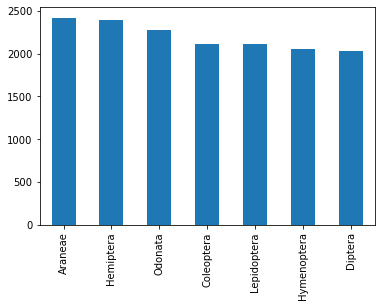

In [4]:

train_data = data
count_col = train_data.labels.value_counts()
count_col.plot(kind = 'bar')

## Data Label encoded

In [5]:
LB = LabelEncoder()
data['encoded labels']= LB.fit_transform(data['labels'])
data.head()

,images,labels,encoded labels
0,0019ce6cda02.jpg,Araneae,0
1,003eb3db1665.jpg,Araneae,0
2,00594c648f4d.jpg,Araneae,0
3,007e1a3a7667.jpg,Araneae,0
4,00befcd5211d.jpg,Araneae,0


In [6]:
dataset = len(data)
range(dataset)

range(0, 15376)

In [7]:
from sklearn.model_selection import train_test_split #because data.labels is not csv read dataframe cant read train,val list into dataloaders
train_list, val_list = train_test_split(data.labels, stratify = data['labels'], test_size=0.3)

## Train Test Split

Using Numpy we train validation split from scratch

In [8]:
dataset_size = len(data)
shuffle_dataset = True
random_seed= 42
indices = list(range(dataset_size))
split = int(np.floor(0.3 * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_ind, val_ind = indices[split:], indices[:split]

In [9]:
print(f"Train data: {len(train_list)}")
print(f"valid data: {len(val_list)}")


Train data: 10763
valid data: 4613


In [10]:
print(f"Train data: {len(train_ind)}")
print(f"valid data: {len(val_ind)}")


Train data: 10764
valid data: 4612


## Dataset class

In [11]:

class ArTax_dataset(Dataset):
    def __init__(self,img_path,img_data,transform=None): #img_data passed to dataloaders should be pandas dataframe not a list as train, val list by train_test_split
        self.img_path = img_path                         #for that reason we split with our own numpy split and use subsapmler for shuffling
        self.img_data = img_data
        self.transform = transform

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self,index): #__getitem__() return a specific type for a single data point (like a tensor, numpy array etc.), otherwise, in the data loader you will get an error
        img = os.path.join(self.img_path, self.img_data.loc[index, 'labels'], self.img_data.loc[index, 'images']) #Also only pandas dataframe has .loc attribute
        image = Image.open(img)
        label = torch.tensor(self.img_data.loc[index,'encoded labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label


## Data Augmentation

In [12]:

train_transform=transforms.Compose([
          transforms.Resize((224,224)),
          transforms.RandomVerticalFlip(),
          transforms.RandomRotation(20),
          transforms.ToTensor(),
          transforms.RandomHorizontalFlip(p=0.7),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
                              ]
        )

valid_transform=transforms.Compose([
          transforms.Resize((224,224)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
                              ]
        )

## Sampler to shuffle data

In [13]:

train_sampler = SubsetRandomSampler(train_ind)
valid_sampler = SubsetRandomSampler(val_ind)

## Datasets and DataLoaders

In [14]:

train_dataset = ArTax_dataset(img_data=data, img_path=Path, transform=train_transform)
valid_dataset = ArTax_dataset(img_data=data, img_path=Path, transform=valid_transform)

In [15]:
trainloader= torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler= train_sampler )
print(len(trainloader))
validloader= torch.utils.data.DataLoader(valid_dataset, batch_size=32, sampler=valid_sampler)
print(len(validloader))


337
145


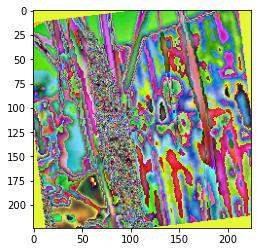

In [16]:
#commentout the normalization in cifar10 train data to see unnormalized img
npimg = next(iter(trainloader))[0][0]
plt.imshow(transforms.ToPILImage()(npimg))


## Train Data Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([32, 3, 224, 224])


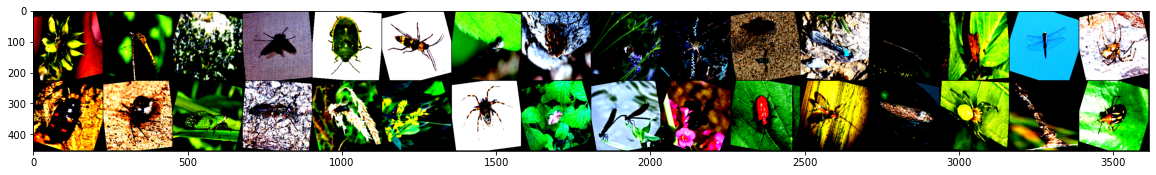

In [17]:
from torchvision.utils import make_grid
for images, _ in trainloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(20,10))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## VAlidation Data Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([32, 3, 224, 224])


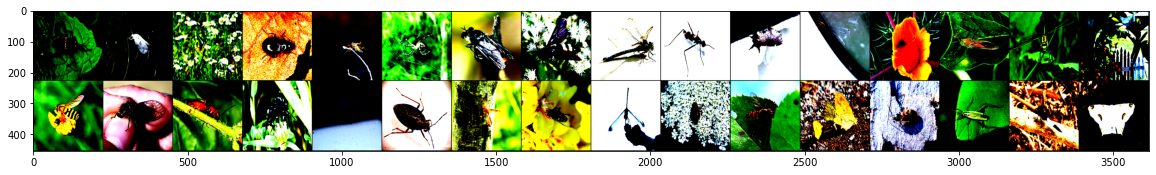

In [18]:
for images, _ in validloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(20,10))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [19]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device : {device}.")

Training on device : cuda.


## Training Loop

In [20]:
import datetime

def TrainingLoop (epoch, model, loss_fn, optimizer, trainloader):

    train_epochLoss_hist = []
    train_epochAcc_hist = []
    valid_epochLoss_hist = []
    valid_epochAcc_hist = []
    for epoch in range(1, epoch+1):
         
         epoch_loss = 0
         train_correct = 0
         train_total = 0
         for data, label in trainloader:
            label = label.type(torch.LongTensor) #to avoid runtime error
            data = data.to(device)
            label = label.to(device)
        
            output = model(data)
            loss = loss_fn(output, label)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss +=loss.item()
            _,tpredicted = torch.max(output, dim=1)
            train_total += label.shape[0]
            train_correct += int((tpredicted == label).sum())
            
            train_epochLoss = (epoch_loss/len(trainloader))
            train_epochAcc = (float(train_correct) / float(train_total) * 100)

         if epoch == 1 or epoch %10 == 0:
          print(f"Loss in train epoch {epoch} : {epoch_loss/len(trainloader)} : date and time : {datetime.datetime.now()} : Got {train_correct} / {train_total} with train accuracy of :{float(train_correct) / float(train_total) * 100:.2f}")
          train_epochLoss_hist.append(train_epochLoss)
          train_epochAcc_hist.append(train_epochAcc)
    
         with torch.no_grad():
              valid_loss = 0
              correct = 0
              total = 0
              for data, label in validloader:
                  label = label.type(torch.LongTensor)
                  data = data.to(device=device)
                  label = label.to(device=device)
            # Forward Pass
                  val_output = model(data)
                  val_loss = loss_fn(val_output, label)
                  valid_loss += val_loss.item()
                  _, vpredicted = torch.max(val_output, dim=1)
                  total += label.shape[0]
                  correct += int((vpredicted == label).sum())

                  valid_epochLoss = (valid_loss/len(validloader))
                  valid_epochAcc = (float(correct) / float(total) * 100)
              if epoch == 1 or epoch %10 == 0:
               print(
                   f"Loss in Valid epoch {epoch} : {valid_loss/len(validloader)} : Got {correct} / {total} with valid accuracy of :{float(correct) / float(total) * 100:.2f}")
               valid_epochLoss_hist.append(valid_epochLoss)
               valid_epochAcc_hist.append(valid_epochAcc)
        
    import matplotlib.pyplot as plt

    valid_losses = valid_epochLoss_hist
    train_losses = train_epochLoss_hist

    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(valid_losses,label="val")
    plt.plot(train_losses,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    valid_acc = valid_epochAcc_hist
    train_acc = train_epochAcc_hist

    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Accuracy")
    plt.plot(valid_acc,label="val")
    plt.plot(train_acc,label="train")
    plt.xlabel("iterations")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

## Resnet50 Model Architecture
ConvNet as fixed feature extractor. Take a ConvNet pretrained on ImageNet, remove the last fully-connected layer (this layer’s outputs are the 1000 class scores for a different task like ImageNet), then treat the rest of the ConvNet as a fixed feature extractor for the new dataset.
New dataset is small and similar to original dataset. Since the data is small, it is not a good idea to fine-tune the ConvNet due to overfitting concerns. Since the data is similar to the original data, we expect higher-level features in the ConvNet to be relevant to this dataset as well. Hence, the best idea might be to train a linear classifier on the CNN codes.

additional info-->>https://cs231n.github.io/transfer-learning/

In [21]:
from torchvision.models import resnet50
Net50 = resnet50(pretrained = True)

# Modifying head of the classifier

Net50.fc = nn.Sequential(
    nn.Dropout(0.3), #dropout incoming last convnet's few features
    nn.Linear(2048, 7)
)


## Losses
If you are dealing with a classification use case and would like to use nn.CrossEntropyLoss, you should pass the raw logits to the loss function (i.e. no final non-linearity), since nn.LogSoftmax and nn.NLLLoss will be called internally.
However, if you would like to use nn.NLLLoss, you should add the nn.LogSoftmax manually.

In [22]:
model = Net50.to(device=device) #remove () from net with transfer learning models
optimizer = optim.SGD(model.parameters(), lr=1e-3) 
loss_fn = nn.CrossEntropyLoss()


Loss in train epoch 1 : 1.7328127106148694 : date and time : 2022-04-16 11:36:12.799595 : Got 3876 / 10764 with train accuracy of :36.01
Loss in Valid epoch 1 : 1.470305848121643 : Got 2456 / 4612 with valid accuracy of :53.25
Loss in train epoch 10 : 0.6741191307055137 : date and time : 2022-04-16 13:55:41.618276 : Got 8193 / 10764 with train accuracy of :76.11
Loss in Valid epoch 10 : 0.6930133052941027 : Got 3502 / 4612 with valid accuracy of :75.93
Loss in train epoch 20 : 0.46344132805436583 : date and time : 2022-04-16 16:43:00.887234 : Got 8987 / 10764 with train accuracy of :83.49
Loss in Valid epoch 20 : 0.6211795558189523 : Got 3605 / 4612 with valid accuracy of :78.17


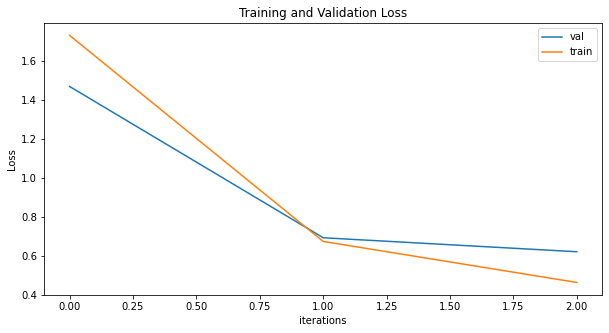

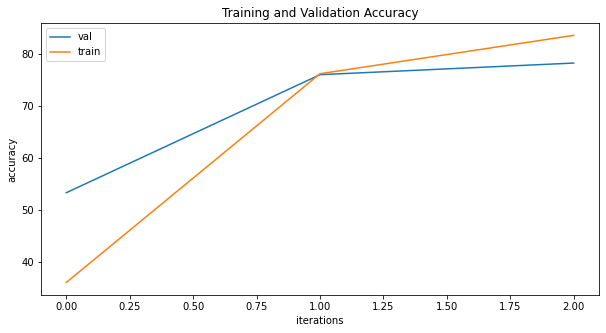

In [23]:

 
TrainingLoop(
      epoch = 20,
      optimizer = optimizer,
      model = model,
      loss_fn = loss_fn,
      trainloader = trainloader,
 )



## save and load the model

In [24]:
torch.save(model.state_dict(), "resnet50_ArTax.pt") #save the model

In [25]:
model =Net50
model.load_state_dict(torch.load("/CV_projects/Arthropod_tax/ArTaxOr/resnet50_ArTax.pt"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Data validation

In [26]:

total = 0
correct = 0

with torch.no_grad():
    for imgs, labels in validloader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                output = model(imgs)
                _, predicted = torch.max(output, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
    print(
              f"Got {correct} / {total} with test accuracy {float(correct) / float(total) * 100:.2f}"
)


Got 3712 / 4612 with test accuracy 80.49
